# Projeto 2 - Transfer Learning
Matheus Arataque Uema - 10276949

Dhyogo Nunes Costa - 13096109


---


Este projeto envolve usar a rede MobileNetV2, treinada com a base Imagenet e adapta--la para reconhecer dados da base "cats and dogs".

##  Etapa 1 - Base de dados
Será utilizada a base "cats and dogs" , disponível em: https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip. Observe que o dataset já vem dividido em treino e teste

In [101]:
train_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

## Etapa 2 - Pré-processamento
Os dados serão redimensionados para o tamanho 160x160, utilizando batches de tamanho 32 e com seus valores escalados para o intervalo 0 e 1.
Para simplificar esse processo, a classe `tf.keras.preprocessing.image.ImageDataGenerator` (com parâmetro rescale), e seu `método flow_from_directory` (com parâmetros `validation_dir, target_size, batch_size e class_mode`) serão utilizados.

Como não há um conjunto de teste no dataset original, um será criado. Para isso, serão determinados lotes de dados do conjunto de validação através do ```validation_split``` e 20% deles serão considerados conjunto de teste

In [102]:
import tensorflow as tf

# Configuração do ImageDataGenerator para reescalonar as imagens
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, validation_split=0.8)

# Carregar as imagens a partir do diretório com redimensionamento e batch size definidos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    target_size=(160, 160),  # Redimensiona as imagens para 160x160
    batch_size=32,           # Define o tamanho do batch como 32
    class_mode='binary',     # Configura a classificação binária para gatos e cachorros
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=True,
    subset='validation',
    target_size=(160, 160),  # Redimensiona as imagens para 160x160
    batch_size=32,           # Define o tamanho do batch como 32
    class_mode='binary'      # Configura a classificação binária para gatos e cachorros
)

test_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=True,
    subset='training',
    target_size=(160, 160),  # Redimensiona as imagens para 160x160
    batch_size=32,           # Define o tamanho do batch como 32
    class_mode='binary'      # Configura a classificação binária para gatos e cachorros
)

print('Number of validation batches:', int(validation_generator.samples/32))
print('Number of test batches:', int(test_generator.samples/32))


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Number of validation batches: 25
Number of test batches: 6


Mostrando exemplos e rótulos do conjunto de treinamento

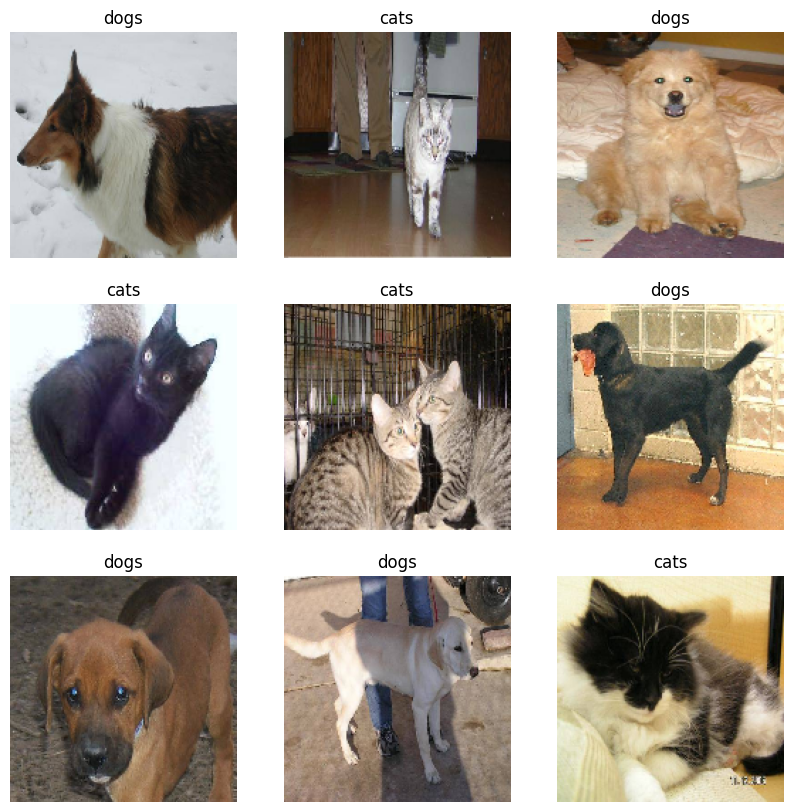

In [103]:
from matplotlib import pyplot as plt
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(class_names[int(labels[i])])
  plt.axis("off")


### 2.1 Data Augmentation

Como o conjunto de dados é reduzido. Será introduzida artificialmente uma diversidade de amostras por transformações aleatórias às imagens de treinamento, como rotação e inversão horizontal. Dessa forma, diferentes aspectos dos dados ficam expostas, reduzindo o overfitting.

In [104]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Aplicando repetidamente a camada na mesma imagem:

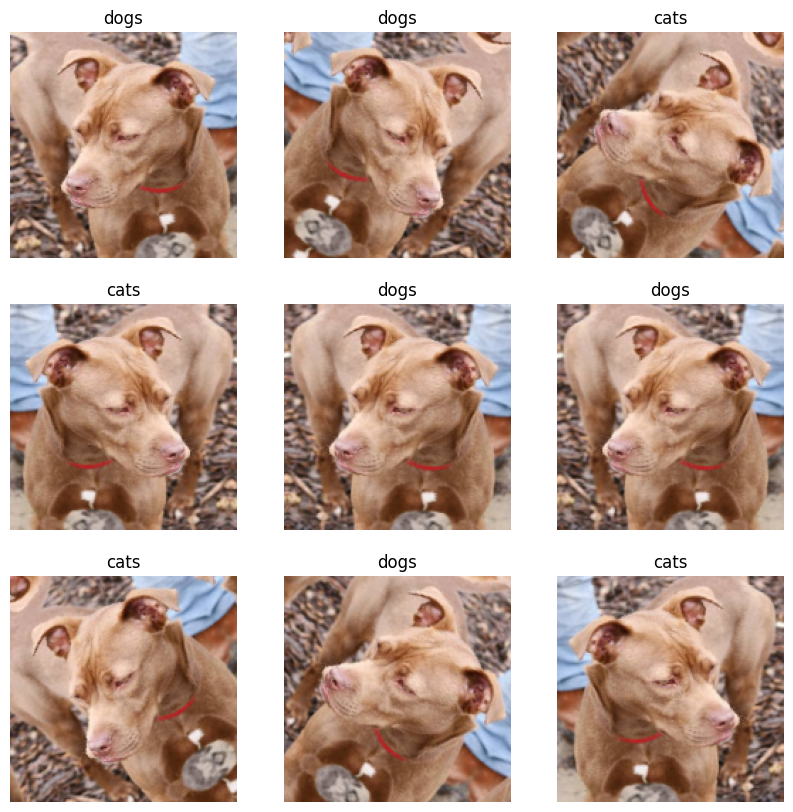

In [105]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
  augmented_image = data_augmentation(tf.expand_dims(images[0], 0))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.title(class_names[int(labels[i])])
  plt.axis("off")

## Etapa 3 - Arquitetura da rede MobileNetV2
A MobileNetV2 foi arquitetada visando leveza e eficiência. Para isso, ela minimiza o número de operações e parâmetros através de convoluções de profundidade separável e blocos invertidos residuais. Sua arquitetura pode ser definida da seguinte forma:

**Primeira camada de convolução**: possui 32 filtros e stride de 2, seguida de uma camada de normalização Batch Normalization e ativação ReLU6.

**Blocos invertidos residuais**: consistem em uma convolução 1x1 para expansão, uma consolução depthwise separável (3x3 com stride de 1 ou 2), uma convolução 1x1 para compressão, resíduo entre entrada e saída e a maioria utiliza ReLU6 como ativação.

**Blocos de Expansão e Projeção**: possui uma fase de expansão - aumentando a representação dimensional - onde o número de filtros aumenta e uma de projeção - reduzindo a redundância - onde o número de filtros reduz.

**Bloco Final de Convolução**: camada de convolução 1x1 com 1280 filtros.

**Pooling Global**:  reduz a dimensão espacial para 1x1

**Camada de Saída**: camada totalmente conectada que utiliza softmax para classificação com múltiplas classes e sigmoid para classificação binária

Essa arquitetura reduz o custo computacional através das convoluções empregadas. Além disso, como a maioria das camadas é configurável com fatores de `width multiplier` e `resolution multiplier`, são permitidos ajustes no tamanho da rede e na resolução da entrada, otimizando seu uso. Por conta disso, a MobileNetV2 é altamente precisa para tarefas de visão, como classificação de imagens e detecção de objetos.

Será utilizado o modelo MobileNetV2 com os pesos do ImageNet e sem as camadas totalmente conectadas. Seus pesos serão congelados, o que pode ser verificado no código abaixo.

Como esses modelos possuem camadas de BatchNormalization, deve ser considerado um caso especial. Quando os pesos são congelados, essa camada é executada no modo de inferência, não atualizando suas estatísticas de média e variação. Isso pode destruir o aprendizado do modelo caso ele seja descongelado sem a manutenção dessas camadas como ```False```.

In [106]:
from keras.applications.mobilenet_v2 import MobileNetV2

# Carregar o modelo MobileNetV2 com pesos do ImageNet e sem as camadas totalmente conectadas
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Extração de recursos
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Congelar os pesos do modelo
base_model.trainable = False

# Verificar a estrutura do modelo e confirmar que as camadas estão congeladas
base_model.summary()

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0   

As camadas da base de dados serão adicionadas através de uma camada totalmente conectada. Para fins de simplificação, uma camada `GlobalAveragePooling2D` será utilizada no treino, o qual utilizará como métrica a acurácia.

In [107]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Adicionar novas camadas no topo do modelo
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)  # Reduz a dimensão espacial
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária

# Criar o modelo final
model = Model(inputs, outputs)

# Compilar o modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281

### 3.1 Treinamento do modelo

In [108]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

d:\Desktop\github\Transfer-Learning-NN\python-venv\lib\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 7s 248ms/step - loss: 0.6721 - accuracy: 0.6075
initial loss: 0.67
initial accuracy: 0.61
Epoch 1/10
63/63 [==============================] - 31s 456ms/step - loss: 0.6299 - accuracy: 0.6590 - val_loss: 0.4718 - val_accuracy: 0.8062
Epoch 2/10
63/63 [==============================] - 30s 479ms/step - loss: 0.5018 - accuracy: 0.7580 - val_loss: 0.3663 - val_accuracy: 0.8838
Epoch 3/10
63/63 [==============================] - 33s 517ms/step - loss: 0.4147 - accuracy: 0.8200 - val_loss: 0.3010 - val_accuracy: 0.9112
Epoch 4/10
63/63 [==============================] - 30s 482ms/step - loss: 0.3610 - accuracy: 0.8525 - val_loss: 0.2604 - val_accuracy: 0.9262
Epoch 5/10
63/63 [==============================] - 30s 484ms/step - loss: 0.3364 - accuracy: 0.8595 - val_loss: 0.2309 - val_accuracy: 0.9388
Epoch 6/10
63/63 [==============================] - 30s 483ms/step - loss: 0.3119 - accuracy: 0.8760 - val_loss: 0.2110 - val_accuracy: 0.9375
Epoch 7/10


#### Curvas de aprendizado do modelo

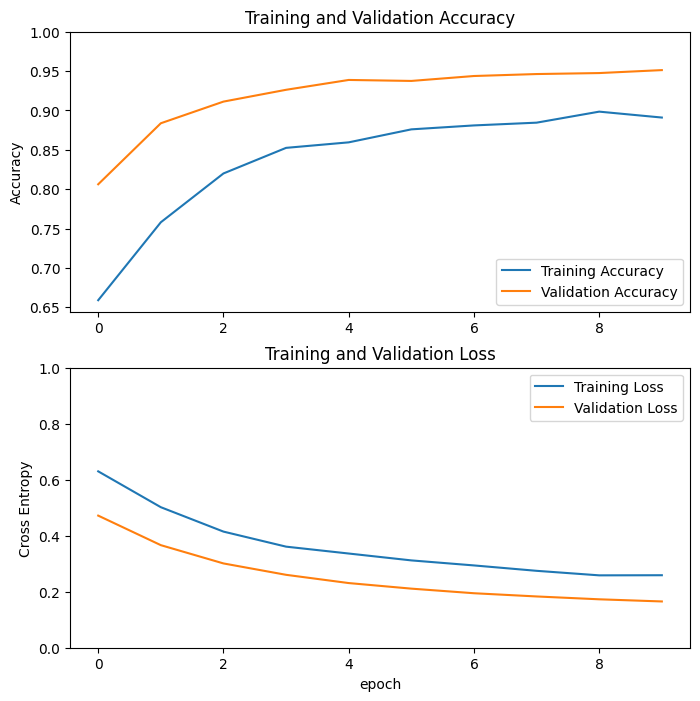

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Etapa 4 - Validação

Avaliando acurácia do modelo no conjunto de teste.

E, serão utilizadas três imagens de gatos e três imagens de cachorros para validação do modelo criado.


In [110]:
import numpy as np
from tensorflow.keras.preprocessing import image

_, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

# Função para pré-processar uma imagem e fazer a previsão
def preprocess_and_predict(img_path, model):
    img = image.load_img(img_path, target_size=(160, 160))  # Carregar e redimensionar a imagem
    img_array = image.img_to_array(img) / 255.0             # Converter para array e escalar
    img_array = np.expand_dims(img_array, axis=0)           # Expandir a dimensão para batch
    prediction = model.predict(img_array)                   # Fazer a previsão
    return prediction[0][0]                                 # Retorna a previsão

# Caminhos para as imagens de gatos e cachorros
image_paths = [
    'cat1.jpg',
    'cat2.jpg',
    'cat3.jpg',
    'dog1.jpg',
    'dog2.jpg',
    'dog3.jpg',
]

# Realizar a previsão e exibir o resultado
for img_path in image_paths:
    pred = preprocess_and_predict(img_path, model)
    label = "Dog" if pred > 0.5 else "Cat"  # Limite de 0.5 para classificação binária
    print(f"Image: {img_path} - Predicted Label: {label} - Confidence: {pred}")


7/7 [==============================] - 2s 270ms/step - loss: 0.1318 - accuracy: 0.9650
Test accuracy : 0.9649999737739563
1/1 [==============================] - 1s 916ms/step
Image: cat1.jpg - Predicted Label: Cat - Confidence: 0.013650215230882168
1/1 [==============================] - 0s 38ms/step
Image: cat2.jpg - Predicted Label: Cat - Confidence: 0.020129160955548286
1/1 [==============================] - 0s 43ms/step
Image: cat3.jpg - Predicted Label: Cat - Confidence: 0.004932690411806107
1/1 [==============================] - 0s 48ms/step
Image: dog1.jpg - Predicted Label: Dog - Confidence: 0.6865257620811462
1/1 [==============================] - 0s 46ms/step
Image: dog2.jpg - Predicted Label: Dog - Confidence: 0.8415775299072266
1/1 [==============================] - 0s 41ms/step
Image: dog3.jpg - Predicted Label: Dog - Confidence: 0.9217710494995117


## Etapa 5 - Afinação do modelo
Os pesos serão descongelados para aumentar o desempenho do modelo, ajustando um pequeno número das camadas superiores

In [111]:
base_model.trainable = True

# Quantidade de camadas do base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune a partir dessa layer
fine_tune_at = 100

# Congelando todas layers anteriores
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Compilação do modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  154
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, None, None, None   0         
                             )                                   
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                  

56

#### Etapa 5.1 Treinamento do modelo

In [112]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/20
63/63 [==============================] - 50s 709ms/step - loss: 0.1947 - accuracy: 0.9195 - val_loss: 0.0906 - val_accuracy: 0.9675
Epoch 11/20
63/63 [==============================] - 42s 671ms/step - loss: 0.1449 - accuracy: 0.9380 - val_loss: 0.0911 - val_accuracy: 0.9700
Epoch 12/20
63/63 [==============================] - 42s 673ms/step - loss: 0.1426 - accuracy: 0.9405 - val_loss: 0.0822 - val_accuracy: 0.9725
Epoch 13/20
63/63 [==============================] - 42s 672ms/step - loss: 0.1282 - accuracy: 0.9485 - val_loss: 0.0758 - val_accuracy: 0.9712
Epoch 14/20
63/63 [==============================] - 42s 667ms/step - loss: 0.1170 - accuracy: 0.9540 - val_loss: 0.0742 - val_accuracy: 0.9737
Epoch 15/20
63/63 [==============================] - 43s 681ms/step - loss: 0.1069 - accuracy: 0.9570 - val_loss: 0.0702 - val_accuracy: 0.9737
Epoch 16/20
63/63 [==============================] - 43s 681ms/step - loss: 0.1081 - accuracy: 0.9555 - val_loss: 0.0719 - val_accuracy:

#### Etapa 5.2 Análise do ajuste fino

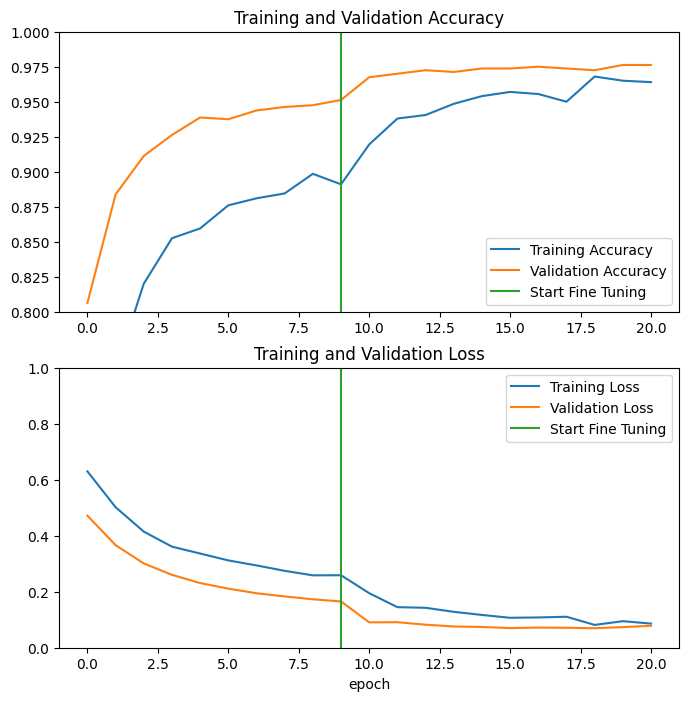

In [113]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Vale ressaltar que os resultados de validação são superiores por conta do ```BatchNormalizaton``` e do ```Dropout```. Essas duas camadas afetam a acurácia no treinamento, no entanto elas são desligadas na validação

## Etapa 6 Avaliação e Previsão
Avaliando o a acurácia do modelo no conjunto de testes separado e aplicando a predição nas mesmas imagens utilizadas anteriormente

In [114]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

7/7 [==============================] - 2s 263ms/step - loss: 0.0781 - accuracy: 0.9750
Test accuracy : 0.9750000238418579


In [115]:

# Realizar a previsão e exibir o resultado
for img_path in image_paths:
    pred = preprocess_and_predict(img_path, model)
    label = "Dog" if pred > 0.5 else "Cat"  # Limite de 0.5 para classificação binária
    print(f"Image: {img_path} - Predicted Label: {label} - Confidence: {pred}")

1/1 [==============================] - 1s 836ms/step
Image: cat1.jpg - Predicted Label: Cat - Confidence: 0.0006289218435995281
1/1 [==============================] - 0s 48ms/step
Image: cat2.jpg - Predicted Label: Cat - Confidence: 0.001305640209466219
1/1 [==============================] - 0s 46ms/step
Image: cat3.jpg - Predicted Label: Cat - Confidence: 0.0014057933585718274
1/1 [==============================] - 0s 44ms/step
Image: dog1.jpg - Predicted Label: Dog - Confidence: 0.9503129124641418
1/1 [==============================] - 0s 45ms/step
Image: dog2.jpg - Predicted Label: Dog - Confidence: 0.9992611408233643
1/1 [==============================] - 0s 306ms/step
Image: dog3.jpg - Predicted Label: Dog - Confidence: 0.9960804581642151
